In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import shutil
from shutil import copyfile


In [40]:
def find_nearest_coast_point(i,j,mask,nseuil):
    out_i=[]
    out_j=[]
    n=1
    var=0
    while (var==0) and (n<nseuil):
        if mask[i+n,j]==1:
            out_i=np.append(out_i,[i+n-1])
            out_j=np.append(out_j,[j])
            
        if mask[i-n,j]==1:
            out_i=np.append(out_i,[i-n+1])
            out_j=np.append(out_j,[j])

        if mask[i,j+n]==1:
            out_i=np.append(out_i,[i])
            out_j=np.append(out_j,[j+n-1])

        if mask[i,j-n]==1:
            out_i=np.append(out_i,[i])  
            out_j=np.append(out_j,[j-n+1])  

        n=n+1
        var=len(out_i)
    if var==0:
        return i,j 
    else:
        return out_i, out_j # closest coastal point
        

In [36]:
def place_runoffs_on_zoom(rnf_2Dt_mother_on_zoom,rnf_2Dt_zoom_inout,mask_zoom,e1e2t_zoom,rnf_point_mother,\
                          Nfactor,coordcheck=False,nav_lat_zoom=None,nav_lon_zoom=None,                   \
                          nav_lat_mother=None,nav_lon_mother=None):
    i_mother = rnf_point_mother[0,:]
    j_mother = rnf_point_mother[1,:]
    print(Nfactor)
    i_zoom = Nfactor * (i_mother) + 2 # +2 in order to be at f point and avoid rim point (+1 +1)
    j_zoom = Nfactor * (j_mother) + 2
    ndist= int((Nfactor -1)/2)
    print(ndist)
    nseuil=4
    number=0    
    mask_zoom_inv=np.where(mask_zoom==1,0,1) # invert mask

    for n in range(len(i_mother)):
    ############### TO TEST INDEXATION ---------------------------------------------------------------------
        if coordcheck:   print(nav_lat_mother[int(i_mother[n]),int(j_mother[n])].values,                 \
              nav_lat_zoom[int(i_zoom[n]),int(j_zoom[n])].values)
        if coordcheck:      print(nav_lon_mother[int(i_mother[n]),int(j_mother[n])].values,              \
              nav_lon_zoom[int(i_zoom[n]),int(j_zoom[n])].values)
    for t in range(len(rnf_2Dt_mother_on_zoom[:,0,0])):
        print(t)

        for n in range(len(i_mother)):
            ind_i , ind_j = find_nearest_coast_point(i_zoom[n],j_zoom[n],mask_zoom_inv,nseuil)
#             print(ind_i, ind_j)
#             print(ind_i.shape,ind_j.shape)
#             print("...")
#         #------------------------------------------------------------------------------------------------------
#             ndist= int((Nfactor -1)/2) # (Number of points in mesh along i or j direction / 2) - the central point
#             sum_e1e2t_zoom=np.nansum(e1e2t_zoom[i_zoom[n]-ndist:i_zoom[n]+ndist+1,j_zoom[n]-ndist:j_zoom[n]+ndist+1] \
#             * mask_zoom[i_zoom[n]-ndist:i_zoom[n]+ndist+1,j_zoom[n]-ndist:j_zoom[n]+ndist+1])
#             rnf_2Dt_zoom[t,i_zoom[n]-ndist:i_zoom[n]+ndist+1,j_zoom[n]-ndist:j_zoom[n]+ndist+1]=         \
#             (rnf_2Dt_mother_on_zoom[t,int(i_mother[n]),int(j_mother[n])]/                                \
#             sum_e1e2t_zoom) * e1e2t_zoom[i_zoom[n]-ndist:i_zoom[n]+ndist+1,j_zoom[n]-ndist:j_zoom[n]+ndist+1]

        #----------------------------------------------------------------------------------------------------

            sum_e1e2t_zoom=0
            for n2 in range(len(ind_i)): 
                ind_i_tmp=int(ind_i[n2])
                ind_j_tmp=int(ind_j[n2])
                sum_e1e2t_zoom=sum_e1e2t_zoom + \
                np.nansum(e1e2t_zoom[ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1] \
                * mask_zoom[ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1])

            tmp=0
            for n2 in range(len(ind_i)):
                ind_i_tmp=int(ind_i[n2])
                ind_j_tmp=int(ind_j[n2])
                rnf_2Dt_zoom[t,ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1]= \
                rnf_2Dt_zoom[t,ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1]  \
                + rnf_2Dt_mother_on_zoom[t,int(i_mother[n]),int(j_mother[n])]      \
                * (e1e2t_zoom[ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1]   \
                * mask_zoom[ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1]) \
                / sum_e1e2t_zoom
#                 tmp=tmp + np.nansum(rnf_2Dt_zoom[t,ind_i_tmp-ndist:ind_i_tmp+ndist+1,ind_j_tmp-ndist:ind_j_tmp+ndist+1])
#             print(rnf_2Dt_mother_on_zoom[t,int(i_mother[n]),int(j_mother[n])])
#             print(tmp)

    return rnf_2Dt_zoom

In [4]:
year=2017
# rnf has to be extrapolated on new domain
rnf_inp_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/runoff_eNEATL36_emodnet_on_agrif_parent_y'+str(year)+'.nc'
inp_domain_cfg_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/DOMAIN_CFG_FINALDOMAIN/domain_cfg.nc'
out_domain_cfg_zoom_file='/data/vdi/tbrivoal/PRE_PROCESSING_IMMERSE/RUNOFFS_eNEATL36/DOMAIN_CFG_FINALDOMAIN/1_domain_cfg.nc'
output_folder="/data/rd_exchange/tbrivoal/RUNOFFS_eNEATL36/"

In [5]:
# Open files
inp_rnf_2Dt=xr.open_dataset(rnf_inp_file)
inp_domain_cfg=xr.open_dataset(inp_domain_cfg_file,drop_variables={"x", "y",})
out_domain_cfg_zoom=xr.open_dataset(out_domain_cfg_zoom_file,drop_variables={"x", "y",})


In [6]:
# Namelist :
# parameters in AGRIF_Fixed_grid.in (DO NOT CONVERT IN PYTHON) 220 1073 350 1245
xmin_zoom=220
xmax_zoom=1073
ymin_zoom=350
ymax_zoom=1245
Nfactor=3 #zoom refinement factor
coordcheck=True


In [27]:
# Open variables
# mask_inp =  inp_domain_cfg.top_level.squeeze()
mask_zoom =  out_domain_cfg_zoom.top_level.squeeze().values # avoid earth boundary point but keep rim 
e1e2t_zoom =  out_domain_cfg_zoom.e1t.squeeze().values * out_domain_cfg_zoom.e2t.squeeze().values
e1e2t_mother =  inp_domain_cfg.e1t.squeeze().values * inp_domain_cfg.e2t.squeeze().values

# mask_inp = maskf.tmask[0,0,:,:].squeeze()
rnf_2Dt_mother=inp_rnf_2Dt.runoffs_instant[:,:,:]


In [28]:
# Convert to python indexation
xmin=xmin_zoom-1
xmax=xmax_zoom-1
ymin=ymin_zoom-1
ymax=ymax_zoom-1 

# Select zoom area in rnf file
rnf_2Dt_mother_on_zoom=rnf_2Dt_mother[:,ymin:ymax+1,xmin:xmax+1].values  *e1e2t_mother[ymin:ymax+1,xmin:xmax+1] # trick to avoid rounding errors 
nav_lat_mother=inp_domain_cfg.gphit.squeeze()[ymin:ymax+1,xmin:xmax+1]
nav_lon_mother=inp_domain_cfg.glamt.squeeze()[ymin:ymax+1,xmin:xmax+1]
nav_lat_zoom=out_domain_cfg_zoom.gphit.squeeze()[:,:]
nav_lon_zoom=out_domain_cfg_zoom.glamt.squeeze()[:,:]
print(np.nansum(rnf_2Dt_mother_on_zoom[0,:,:]))
rnf_2Dt_mother_on_zoom.shape




18873339.420869432


(365, 896, 854)

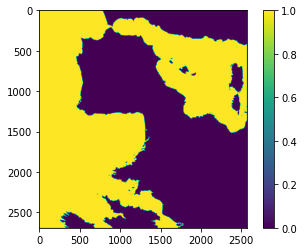

In [10]:
plt.imshow(mask_zoom)
plt.colorbar()

In [41]:

rnf_2Dt_zoom=np.zeros((int(len(rnf_2Dt_mother[:,0,0])),int(len(mask_zoom[:,0])),int(len(mask_zoom[0,:]))))
rnf_point_mother = np.array(np.where(rnf_2Dt_mother_on_zoom[0,:,:]>0)) # assuming runoffs does not move
# rnf_2Dt_zoom[:,:,:] = place_runoffs_on_zoom(rnf_2Dt_mother_on_zoom[:,:,:],rnf_2Dt_zoom[:,:,:]\
#                                                       ,mask_zoom[:,:],e1e2t_zoom[:,:],      \
#                                                       rnf_point_mother, True,               \
#                                                       nav_lat_zoom,nav_lon_zoom,            \
#                                                       nav_lat_mother, nav_lon_mother)

rnf_2Dt_zoom[:,:,:] = place_runoffs_on_zoom(rnf_2Dt_mother_on_zoom[0:3,:,:],rnf_2Dt_zoom[0:3,:,:]\
                                                      ,mask_zoom[:,:],e1e2t_zoom[:,:],      \
                                                      rnf_point_mother, Nfactor)
rnf_2Dt_zoom = rnf_2Dt_zoom / e1e2t_zoom

3
1
0
1
2


In [42]:

print(np.nansum(rnf_2Dt_zoom[0,:,:] * e1e2t_zoom))


18873339.420869425


In [35]:
rnf_2Dt_mother2=inp_rnf_2Dt.runoffs_instant[:,:,:]
rnf_2Dt_mother_on_zoom2=rnf_2Dt_mother2[:,ymin:ymax+1,xmin:xmax+1].values  *e1e2t_mother[ymin:ymax+1,xmin:xmax+1] # trick to avoid rounding errors 
print(np.nansum(rnf_2Dt_mother_on_zoom2[0,:,:]))

18873339.420869432


18873339.420869432


In [15]:
year=2017 # year of runoff file

# Date variables ----------------------------------------------------------------------------------------
dstart_year= str(year) + "-01-01" # 1st day of the year
dend_year= str(year) + "-12-31" # last day of the year

dstart_clim_monthly = str(year) + "-01-15" # for 12 month clim
dend_clim_monthly = str(year) + "-12-15" # for 12 month clim
dstart_minus_1_month = str(year-1) + "-12-01" # used for conversion from monthly to daily clim data

############################ Save in a Netcdf ###################################
time_counter_daily = pd.date_range(dstart_year,dend_year, freq="D") # time dimension
print(time_counter_daily)
# time_counter_daily_float = pd.to_numeric(time_counter_daily, downcast='float')
#time_counter_daily.values.astype("float")
# Create xarray dataarray
rnf_2Dt_daily_zoom_da = xr.DataArray(
    data=rnf_2Dt_zoom,
    dims=["time_counter", "y", "x"],
    coords=dict(time_counter=time_counter_daily.values),
    attrs=rnf_2Dt_mother.attrs,
    name=rnf_2Dt_mother.name,
     )

nav_lat_da = xr.DataArray(
    data=nav_lat_zoom.values,
    dims=["y", "x"],
    attrs=nav_lat_mother.attrs,
    name=nav_lat_mother.name,
     )

nav_lon_da = xr.DataArray(
    data=nav_lon_zoom.values,
    dims=["y", "x"],
    attrs=nav_lon_mother.attrs,
    name=nav_lon_mother.name,
     )
# Create dataset
ds = xr.merge([rnf_2Dt_daily_zoom_da, nav_lat_da, nav_lon_da])
ds.attrs=inp_rnf_2Dt.attrs
# Save to netcdf
outfile = output_folder + "1_runoff_eNEATL36_with_BDY_y" + str(year) + '_extrap_on_newdomaincfg.nc'  
# outfile = output_folder + "runoff_eNEATL36_with_BDY_y" + str(year) + '.nc'  

ds.to_netcdf(outfile, mode="w")

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')
